<a href="https://colab.research.google.com/github/gmazzitelli/GSN2/blob/master/rateVsSizeAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import seaborn as sns
sns.set()
def panda_from_gspreadsheet(key, sheet_name='Sheet1', header=0):
  # google spredsheet TO panda dataframe 
  # ricordarsi di abilitare lo sharing pubblico dei dati
  url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
      key=key, sheet_name=sheet_name.replace(' ', '%20'))
  return pd.read_csv(url, header=header)

#https://docs.google.com/spreadsheets/d/1MWRb1xbkpZOmUBLCLaC9ud4htvPEWYC7F8IuTt84YBg/
pd =  panda_from_gspreadsheet('1MWRb1xbkpZOmUBLCLaC9ud4htvPEWYC7F8IuTt84YBg', sheet_name='Sheet1')

def Exp(x, p0, p1): # negative exponential
  import numpy as np
  return p0*np.exp(x/p1)

def Line(x, m, q):
  import numpy as np
  return m*x + q
  
def Gain(x, p0, p1):
  import numpy as np
  return p0*x**p1

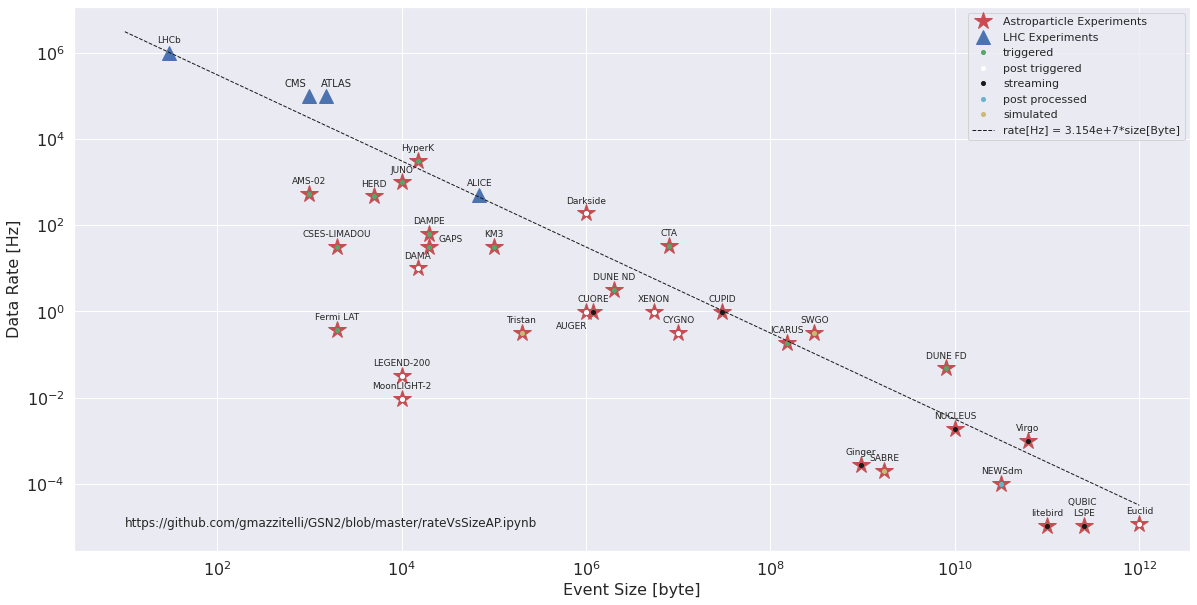

In [2]:
fig, ax = plt.subplots(figsize=(20,10))
lhc_experiment = np.array(["ATLAS", "CMS", "LHCb", "ALICE"])
lhc_size = np.array([1.5e3,1e3,30,70e3])
lhc_rate = np.array([1e5,1e5,1e6,500])
x = np.array(pd["size KB"]*1e3)
y = np.array(pd["DAQ rate events/y"]/3.154e+7)
z = np.array(pd["DAQ type"])

ax.plot(x, y , 'r*', markersize=18, label="Astroparticle Experiments")
ax.plot(lhc_size, lhc_rate , 'b^', markersize=14, label="LHC Experiments")
ax.plot(x[z=="triggered"], y[z=="triggered"] , 'go', markersize=4, label="triggered")
ax.plot(x[z=="post triggered"], y[z=="post triggered"] , 'wo', markersize=4, label="post triggered")
ax.plot(x[z=="streaming"], y[z=="streaming"] , 'ko', markersize=4, label="streaming")

ax.plot(x[z=="post processed"], y[z=="post processed"] , 'co', markersize=4, label="post processed")
ax.plot(x[z=="simulated"], y[z=="simulated"] , 'yo', markersize=4, label="simulated")



# for i in range(len(x)):
#     ax.scatter(x[i], y[i] , marker='*', color=z[i], s=200)



size_day = np.logspace(1, 12, 10)
rate_day = Gain(size_day, 3.154e+7, -1)
ax.plot(size_day, rate_day , 'k--', label="rate[Hz] = 3.154e+7*size[Byte]", linewidth=1)


# popt, pcov = curve_fit(Gain,x, y, p0=[1e7, -1])
# perr = np.sqrt(np.diag(pcov))
# r2=r2_score(y, Gain(x, *popt))
# xf = np.linspace(10, 1e12, 100)
# ax.plot(xf, Gain(xf, *popt), 'k--', label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
# \nr^2 = {4:.3f}'.format(popt[0], perr[0], popt[1], perr[1], r2))


for i, lab in enumerate(pd["Experiment"]):
    d = 0.7 # 1.2 if i%2 == 0 else 1.1
    if lab == "AUGER":
      plt.annotate(lab, (x[i]-(x[i]*0.3),y[i]-(y[i]*0.6)), ha='center', size=9) 
    elif lab == "GAPS":
      plt.annotate(lab, (x[i]+(x[i]*d),y[i]+(y[i]*0.3)), ha='center', size=9) 
    else:
      plt.annotate(lab, (x[i],y[i]+(y[i]*d)), ha='center', size=9) 


plt.annotate(lhc_experiment[0], (lhc_size[0]+lhc_size[0]*0.3,lhc_rate[0]+(lhc_rate[0]*0.7)), ha='center', size=10) 
plt.annotate(lhc_experiment[1], (lhc_size[1]-lhc_size[1]*0.3,lhc_rate[1]+(lhc_rate[1]*0.7)), ha='center', size=10) 
plt.annotate(lhc_experiment[2], (lhc_size[2],lhc_rate[2]+(lhc_rate[2]*0.7)), ha='center', size=9) 
plt.annotate(lhc_experiment[3], (lhc_size[3],lhc_rate[3]+(lhc_rate[3]*0.7)), ha='center', size=9) 

# for i, lab in enumerate(lhc_experiment):
#     d = -0.3 if i%2 == 0 else 0.3
#     plt.annotate(lab, (lhc_size[i]+lhc_size[i]*d,lhc_rate[i]-(lhc_rate[i]*0.7)), ha='center', size=9) 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("Event Size [byte]", size = 16)
ax.set_ylabel("Data Rate [Hz]", size = 16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend()
plt.text(1e1, 1e-5, "https://github.com/gmazzitelli/GSN2/blob/master/rateVsSizeAP.ipynb")
plt.show()

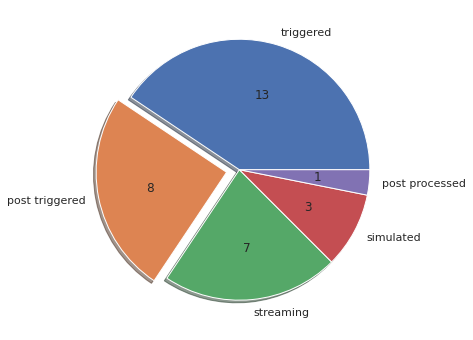

In [3]:
fig, ax = plt.subplots(figsize=(6,6))
colors = ["g", "w", "k", "y", "c"]
explode = [0, 0.1, 0, 0, 0]
elements = len(pd["DAQ type"])
pd.value_counts(pd["DAQ type"]).plot(kind='pie', autopct=lambda x: '{:.0f}'.format(x*elements/100), label="", 
                                     shadow=True, explode=explode)
plt.show()

In [4]:
sa = 3.154e+7
b = sa/1000
b = 2e15/3.2e+04/1e3
"{:.1e}".format(b)


'6.2e+07'

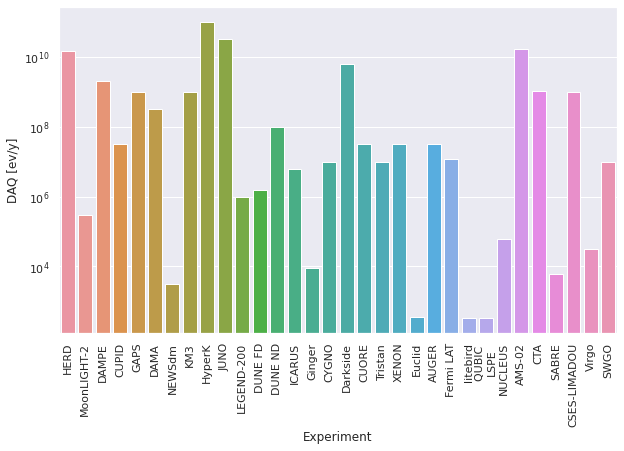

In [5]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="DAQ rate events/y")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("DAQ [ev/y]")
plt.show()

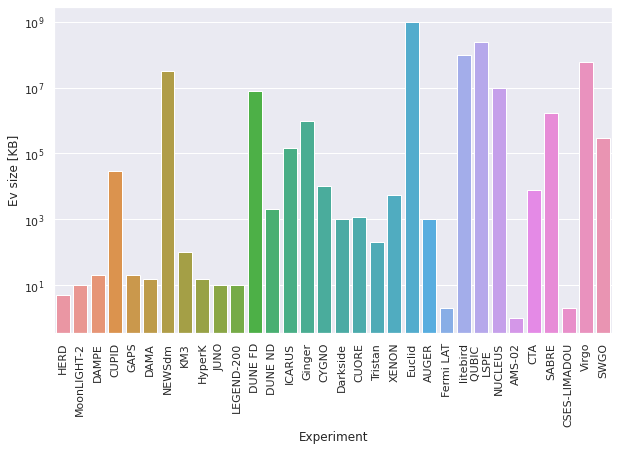

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="size KB")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("Ev size [KB]")
plt.show()

In [7]:
pd[['Email Address', 'Experiment']]

,Email Address,Experiment
0,mori@fi.infn.it,HERD
1,luca.porcelli@lnf.infn.it,MoonLIGHT-2
2,margherita.disanto@gssi.it,DAMPE
3,giovanni.benato@lngs.infn.it,CUPID
4,alessio.tiberio@fi.infn.it,GAPS
5,pierluigi.belli@roma2.infn.it,DAMA
6,valeri@na.infn.it,NEWSdm
7,cbozza@unisa.it,KM3
8,kryss@sa.infn.it,HyperK
9,stefanomaria.mari@uniroma3.it,JUNO


In [8]:
pd.columns

Index(['Timestamp', 'Email Address', 'Experiment', 'DAQ type',
       'Data organization', 'DAQ rate events/y', 'Data amount', 'size KB',
       'Data size', 'Data structure', 'Metadata/calibrations/slow-control',
       'Production sites', 'where', 'where stored', 'Workflow', 'Data access',
       'public', 'Details', 'Details, "arrows"', 'Details, "boxes"',
       'CPU - total amount', 'CPU (160HS06=10core=125GPU)', 'RAM (GB)',
       'CPU - HPC', 'HPC', 'CPU - HTC', 'HTC', 'CPU - interactive',
       'interactive', 'CPU - batch system', 'batch', 'CPU - web based tools',
       'web tool', 'CPU - personal VMs', 'personal VMs',
       'CPU - graphic access', 'graphic access', 'CPU - services', 'services',
       'CPU - temporary overpledge', 'temporary overpledge',
       'CPU - special environment', 'special environment', 'CPU - R&D', 'R&D',
       'Storage - size', 'TB', 'file size GB', 'Storage - experiment data',
       'experiment data', 'Storage - user data', 'Storage - secondar

damp all db

In [9]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
from IPython.display import display
for i, field in enumerate(pd.columns):
  if i> 2:
    # print(field)
    # data = pd[['Experiment', field]].values
    #display(pd[['Experiment', field]])
    display(data_table.DataTable(pd[['Experiment', field]], include_index=False, num_rows_per_page=32))


,Experiment,DAQ type
0,HERD,triggered
1,MoonLIGHT-2,post triggered
2,DAMPE,triggered
3,CUPID,streaming
4,GAPS,triggered
5,DAMA,post triggered
6,NEWSdm,post processed
7,KM3,triggered
8,HyperK,triggered
9,JUNO,triggered


,Experiment,Data organization
0,HERD,By event
1,MoonLIGHT-2,ILRS-defined (lunar) laser ranging data are or...
2,DAMPE,By event
3,CUPID,"For CUPID, the data are a continuous time seri..."
4,GAPS,by event
5,DAMA,by event
6,NEWSdm,Emulsion analysis data more similar to GW wher...
7,KM3,by event
8,HyperK,per event
9,JUNO,by event generated by a trigger


,Experiment,DAQ rate events/y
0,HERD,1.500000e+10
1,MoonLIGHT-2,3.000000e+05
2,DAMPE,2.000000e+09
3,CUPID,3.150000e+07
4,GAPS,1.000000e+09
5,DAMA,3.150000e+08
6,NEWSdm,3.130000e+03
7,KM3,1.000000e+09
8,HyperK,1.000000e+11
9,JUNO,3.150000e+10


,Experiment,Data amount
0,HERD,15*10^9 events/y real + 10^7 events/y MC (we s...
1,MoonLIGHT-2,"For lunar laser ranging, 1000 NP*/year ROM; fo..."
2,DAMPE,Real data: 2 billions/year. MC data: 5 billion...
3,CUPID,The rate of physical events is of the order of...
4,GAPS,~10^9 events/year (simulation)
5,DAMA,The hardware trigger rate of all the running m...
6,NEWSdm,Data volume depends strongly on the level of i...
7,KM3,10^9 events/year (real data);
8,HyperK,"About 1.5 PB/year, but mostly background."
9,JUNO,trigger rate of about 1kHz


,Experiment,size KB
0,HERD,5.000000e+00
1,MoonLIGHT-2,1.000000e+01
2,DAMPE,2.000000e+01
3,CUPID,3.000000e+04
4,GAPS,2.000000e+01
5,DAMA,1.500000e+01
6,NEWSdm,3.200000e+07
7,KM3,1.000000e+02
8,HyperK,1.500000e+01
9,JUNO,1.000000e+01


,Experiment,Data size
0,HERD,5 kB
1,MoonLIGHT-2,Order of 10 kB/NP (https://ilrs.gsfc.nasa.gov/...
2,DAMPE,20 kB/event
3,CUPID,"This doesn't really apply, as our data usage i..."
4,GAPS,~20 kB/event
5,DAMA,15 k
6,NEWSdm,Data logically divided by runs of 0.4-4Tb size...
7,KM3,100 kB
8,HyperK,15 kB at the end of the reconstruction chain.
9,JUNO,10kB; Per quanto riguarda JUNO: 10kB sono “fil...


,Experiment,Data structure
0,HERD,4+5
1,MoonLIGHT-2,Raw (real + MC) --> Calibrated --> Residuals
2,DAMPE,3+2
3,CUPID,Real data are organized in 3 levels: raw conti...
4,GAPS,Simulated - Digitized - Reconstructed
5,DAMA,"raw data, calibrated data, filtered"
6,NEWSdm,Raw data (images included) 40 Gb/cm2 \nPreproc...
7,KM3,raw data (triggered) - calibrated - reconstruc...
8,HyperK,"For real data: raw data format, calibrated for..."
9,JUNO,real: raw + reco-filtered + selected + calibra...


,Experiment,Metadata/calibrations/slow-control
0,HERD,"Yes, slow control (details to be defined)"
1,MoonLIGHT-2,"Yes, they do, when the data is real and genera..."
2,DAMPE,200 metadata/day. 7 GB/year of metadata. Calib...
3,CUPID,"Yes, we have meta-data related to the run type..."
4,GAPS,~1.5 MB (simulation geometry) + ~17 kB (simula...
5,DAMA,"yes, 100 MB/years for slow control data"
6,NEWSdm,Recently no significant volume of metadata exp...
7,KM3,Metadata and slow control data are stored in a...
8,HyperK,Relational databases contain metadata and cali...
9,JUNO,slow-control negligible


,Experiment,Production sites
0,HERD,"Real data: produced in orbit, stored in Italy ..."
1,MoonLIGHT-2,ILRS (https://ilrs.gsfc.nasa.gov/).
2,DAMPE,"Real data are produced in orbit, and stored in..."
3,CUPID,Data are produced at LNGS. They are stored in ...
4,GAPS,"CNAF, local INFN PC farms in Firenze and Tries..."
5,DAMA,"produced at LNGS, stored LNGS and Roma2"
6,NEWSdm,Main data producton done in the scanning labor...
7,KM3,Off-shore the Sicilian coast and the French coast
8,HyperK,"Japan, Canada, Europe"
9,JUNO,IHEP Computing Center Tier0; CNAF Bologna Tier...


,Experiment,where
0,HERD,SPACE
1,MoonLIGHT-2,ILRS
2,DAMPE,SPACE
3,CUPID,LNGS
4,GAPS,CNAF
5,DAMA,LNGS
6,NEWSdm,LNGS
7,KM3,SICILY (KM3)
8,HyperK,Kamioka
9,JUNO,IHEP


,Experiment,where stored
0,HERD,2
1,MoonLIGHT-2,0
2,DAMPE,2
3,CUPID,2
4,GAPS,2
5,DAMA,3
6,NEWSdm,3
7,KM3,3
8,HyperK,3
9,JUNO,2


,Experiment,Workflow
0,HERD,Automated data processing based on HTCondor + ...
1,MoonLIGHT-2,Comprehensevely described in the following: ht...
2,DAMPE,"Real data are produced in orbit, processed in ..."
3,CUPID,We process our data twice: a first processing ...
4,GAPS,Simulation and digitization (one after each ot...
5,DAMA,raw data --> filtered --> stored --> filtered ...
6,NEWSdm,Emulsions (sensitive media) exposed in LNGS ha...
7,KM3,Most processing for raw-data involves a single...
8,HyperK,Multi-tier (at least three-tier) operated most...
9,JUNO,"Tier0: raw data, prompt event classification, ..."


,Experiment,Data access
0,HERD,POSIX filesystem in data centers + XrootD/S3 f...
1,MoonLIGHT-2,ILRS (https://ilrs.gsfc.nasa.gov/).
2,DAMPE,XRootD and POSIX access. In the near future XR...
3,CUPID,The data are accessed via ssh. The number of p...
4,GAPS,data are accessed and copied through ssh with ...
5,DAMA,The whole collaboration can access the data in...
6,NEWSdm,Recently each lab has independent storage and ...
7,KM3,At least all European members should be able t...
8,HyperK,Via DIRAC tools using x509 proxy certificate.
9,JUNO,Collaboration member


,Experiment,public
0,HERD,0
1,MoonLIGHT-2,1
2,DAMPE,0
3,CUPID,0
4,GAPS,0
5,DAMA,0
6,NEWSdm,0
7,KM3,1
8,HyperK,0
9,JUNO,0


,Experiment,Details
0,HERD,As above without FFT level (does not apply)
1,MoonLIGHT-2,Raw (real + MC) --> Calibrated --> Residuals. ...
2,DAMPE,https://www.dropbox.com/s/y5mi9pf0bgte2yd/DAMP...
3,CUPID,https://docs.google.com/presentation/d/1F-Kiuv...
4,GAPS,https://pandora.infn.it/public/dcf46f
5,DAMA,no detail
6,NEWSdm,https://cernbox.cern.ch/index.php/s/d7zsZWNkVz...
7,KM3,https://drive.google.com/file/d/12oUFEZJmCi71H...
8,HyperK,https://docs.google.com/drawings/d/1BJY-0z1YQs...
9,JUNO,https://www.dropbox.com/s/u8l8cn5ddflft5e/Juno...


,Experiment,"Details, ""arrows"""
0,HERD,For every arrow: \n- ~ 200 CPU*year\n- Product...
1,MoonLIGHT-2,CPU-time for real raw data is allocated by the...
2,DAMPE,"Real data are processed in China, while Europe..."
3,CUPID,Denoising will be run daily on newly acquired ...
4,GAPS,a) Simulation and digitization: ~120 s/file (~...
5,DAMA,"daq 8 cpu, analysis 16 cpu"
6,NEWSdm,Each DAQ workstations: CPU 12 core + RTX3070Ti...
7,KM3,See answers in next page
8,HyperK,Answers in the picture.
9,JUNO,Total of about 210KHepSepc06 on HTCondorCE dis...


,Experiment,"Details, ""boxes"""
0,HERD,"Sizes:\n- Real data (raw, calibrated, reco, pr..."
1,MoonLIGHT-2,Size: hundreds of MB maximum and hundreds/thou...
2,DAMPE,- SIMULATIONS: 25 TB/year \n- REAL DATA: 40 TB...
3,CUPID,Raw and continuous data will be ~1 T/day each....
4,GAPS,"1) ~20 kB/event, easier to reproduce\n2) ~1.5 ..."
5,DAMA,standard
6,NEWSdm,100 Tb (data) + 100 Tb (calibration) + 300 Tb ...
7,KM3,See answers in next page
8,HyperK,Answers in the picture.
9,JUNO,Total of about 3PB/year at Tier0 and distribut...


,Experiment,CPU - total amount
0,HERD,"500 processes, 2 GB RAM each"
1,MoonLIGHT-2,2/4 GB per core.
2,DAMPE,"SIMULATIONS : about 3000 jobs, 1 thread/job. 6..."
3,CUPID,"For the daily production, we will need ~20 sin..."
4,GAPS,"~1000 cores in parallel, ~1 GB of RAM used per..."
5,DAMA,a few
6,NEWSdm,Mean CPU needs for MC and data processing is e...
7,KM3,100 threads with 6GB/core on average
8,HyperK,"Single core jobs, 4 GB each. Multicore submiss..."
9,JUNO,about 200KHepSpec06


,Experiment,CPU (160HS06=10core=125GPU)
0,HERD,500.0
1,MoonLIGHT-2,2.0
2,DAMPE,4000.0
3,CUPID,120.0
4,GAPS,1000.0
5,DAMA,16.0
6,NEWSdm,12.5
7,KM3,100.0
8,HyperK,-1.0
9,JUNO,12500.0


,Experiment,RAM (GB)
0,HERD,2.0
1,MoonLIGHT-2,4.0
2,DAMPE,8.0
3,CUPID,4.0
4,GAPS,1.0
5,DAMA,1.0
6,NEWSdm,1.0
7,KM3,6.0
8,HyperK,4.0
9,JUNO,1.0


,Experiment,CPU - HPC
0,HERD,"0 (no plan to use HPC resources at the moment,..."
1,MoonLIGHT-2,We would like to try GPUs.
2,DAMPE,The current fraction of used HCP is less than ...
3,CUPID,We just use HCP and are not planning to use FP...
4,GAPS,0
5,DAMA,no matter
6,NEWSdm,potentially can be used if we move MC and NN t...
7,KM3,0%
8,HyperK,5% for testing. Usage of GPU is planned for th...
9,JUNO,-


,Experiment,HPC
0,HERD,1.0
1,MoonLIGHT-2,1.0
2,DAMPE,2.0
3,CUPID,2.0
4,GAPS,0.0
5,DAMA,0.0
6,NEWSdm,2.0
7,KM3,0.0
8,HyperK,1.0
9,JUNO,0.0


,Experiment,CPU - HTC
0,HERD,100%
1,MoonLIGHT-2,N/A.
2,DAMPE,100%
3,CUPID,Practically everything we do is HTC already.
4,GAPS,0
5,DAMA,no matter
6,NEWSdm,0.5
7,KM3,100%
8,HyperK,5% for testing.
9,JUNO,-


,Experiment,HTC
0,HERD,1.00
1,MoonLIGHT-2,0.00
2,DAMPE,1.00
3,CUPID,1.00
4,GAPS,0.00
5,DAMA,0.00
6,NEWSdm,0.50
7,KM3,1.00
8,HyperK,0.05
9,JUNO,0.00


,Experiment,CPU - interactive
0,HERD,Negligible but non zero (e.g. an 8-core dedica...
1,MoonLIGHT-2,N/A.
2,DAMPE,Less than 5%
3,CUPID,The production data need interactive access be...
4,GAPS,0
5,DAMA,no matter
6,NEWSdm,0.25
7,KM3,10%
8,HyperK,No plan to request now.
9,JUNO,negligible


,Experiment,interactive
0,HERD,0.00
1,MoonLIGHT-2,0.00
2,DAMPE,0.05
3,CUPID,0.50
4,GAPS,0.00
5,DAMA,0.00
6,NEWSdm,0.25
7,KM3,0.10
8,HyperK,0.00
9,JUNO,0.00


,Experiment,CPU - batch system
0,HERD,100%. Currently mostly steady jobs (MC that la...
1,MoonLIGHT-2,N/A.
2,DAMPE,100% HTCondor. The jobs will be 75% steady and...
3,CUPID,"See answer for ""CPU total amount"""
4,GAPS,"100%, mostly steady jobs running for a long ti..."
5,DAMA,none
6,NEWSdm,0.5
7,KM3,10%
8,HyperK,> 90%. Bursts are expected before conferences/...
9,JUNO,"Services based on: DIRAC, Rucio, VOMS, CVMFS, ..."


,Experiment,batch
0,HERD,1.00
1,MoonLIGHT-2,0.00
2,DAMPE,0.95
3,CUPID,0.50
4,GAPS,1.00
5,DAMA,0.00
6,NEWSdm,0.50
7,KM3,0.10
8,HyperK,1.00
9,JUNO,1.00


,Experiment,CPU - web based tools
0,HERD,"Not at the moment, might be revised in future."
1,MoonLIGHT-2,No.
2,DAMPE,"yes, we foresee to use a web-based tool."
3,CUPID,We are discussing the use of Jupyter notebooks...
4,GAPS,No
5,DAMA,none
6,NEWSdm,can be useful
7,KM3,not used so far
8,HyperK,CPU - interactive
9,JUNO,not planned


,Experiment,web tool
0,HERD,0
1,MoonLIGHT-2,0
2,DAMPE,1
3,CUPID,1
4,GAPS,0
5,DAMA,0
6,NEWSdm,2
7,KM3,2
8,HyperK,1
9,JUNO,0


,Experiment,CPU - personal VMs
0,HERD,"Not at the moment, we foresee to consider this..."
1,MoonLIGHT-2,Yes.
2,DAMPE,"No, but we will like to not exclude it."
3,CUPID,No
4,GAPS,No
5,DAMA,none
6,NEWSdm,Considering the unusual data processing tools ...
7,KM3,not used so far
8,HyperK,not for the moment
9,JUNO,not planned


,Experiment,personal VMs
0,HERD,2
1,MoonLIGHT-2,1
2,DAMPE,0
3,CUPID,0
4,GAPS,0
5,DAMA,0
6,NEWSdm,1
7,KM3,0
8,HyperK,0
9,JUNO,0


,Experiment,CPU - graphic access
0,HERD,No
1,MoonLIGHT-2,No.
2,DAMPE,"No, but we will like to not exclude it."
3,CUPID,"Yes, to the interactive resources."
4,GAPS,No
5,DAMA,X server
6,NEWSdm,yes
7,KM3,No
8,HyperK,no plans to request this
9,JUNO,-


,Experiment,graphic access
0,HERD,0
1,MoonLIGHT-2,0
2,DAMPE,2
3,CUPID,1
4,GAPS,0
5,DAMA,1
6,NEWSdm,1
7,KM3,0
8,HyperK,0
9,JUNO,0


,Experiment,CPU - services
0,HERD,"Yes. We will need database, data access (e.g. ..."
1,MoonLIGHT-2,No.
2,DAMPE,"We need cvmfs, XRootD server. \nThe computing ..."
3,CUPID,Yes. We use a PSQL database that needs to be a...
4,GAPS,No
5,DAMA,no
6,NEWSdm,not for now
7,KM3,CVMFS required; DIRAC support and some grid re...
8,HyperK,Singularity and CVMFS.
9,JUNO,"Services based on: DIRAC, Rucio, VOMS, CVMFS, ..."


,Experiment,services
0,HERD,1
1,MoonLIGHT-2,0
2,DAMPE,1
3,CUPID,1
4,GAPS,0
5,DAMA,0
6,NEWSdm,0
7,KM3,1
8,HyperK,1
9,JUNO,1


,Experiment,CPU - temporary overpledge
0,HERD,Yes. Cloud resources would be fully effective ...
1,MoonLIGHT-2,Possibly yes.
2,DAMPE,"Yes, we definitely would like to have this pos..."
3,CUPID,"Yes, we foresee yearly overpledges of the dura..."
4,GAPS,No
5,DAMA,no
6,NEWSdm,cloud services could be effective
7,KM3,temporary overpledge might be needed - cloud c...
8,HyperK,"This could be needed, but cloud resources requ..."
9,JUNO,-


,Experiment,temporary overpledge
0,HERD,1
1,MoonLIGHT-2,1
2,DAMPE,1
3,CUPID,1
4,GAPS,0
5,DAMA,0
6,NEWSdm,1
7,KM3,1
8,HyperK,1
9,JUNO,0


,Experiment,CPU - special environment
0,HERD,All the steps require custom software develope...
1,MoonLIGHT-2,The environment is tailored because of the req...
2,DAMPE,All our computing access software on cvmfs. Th...
3,CUPID,"Yes, but we are planning a major rewriting of ..."
4,GAPS,No tailored environment required. We plan to u...
5,DAMA,no
6,NEWSdm,80%
7,KM3,Singularity from CVMFS; modules system
8,HyperK,No
9,JUNO,-


,Experiment,special environment
0,HERD,NaN
1,MoonLIGHT-2,NaN
2,DAMPE,NaN
3,CUPID,NaN
4,GAPS,NaN
5,DAMA,NaN
6,NEWSdm,NaN
7,KM3,NaN
8,HyperK,NaN
9,JUNO,NaN


,Experiment,CPU - R&D
0,HERD,"Yes, we plan to continue developing the cloud ..."
1,MoonLIGHT-2,"Yes, we are working on it, as part of our usua..."
2,DAMPE,no.
3,CUPID,"Yes, but we don't know yet how many resources ..."
4,GAPS,No
5,DAMA,no
6,NEWSdm,no
7,KM3,No
8,HyperK,We may test multi-threaded jobs and may test G...
9,JUNO,no


,Experiment,R&D
0,HERD,1
1,MoonLIGHT-2,1
2,DAMPE,0
3,CUPID,1
4,GAPS,0
5,DAMA,0
6,NEWSdm,0
7,KM3,0
8,HyperK,1
9,JUNO,0


,Experiment,Storage - size
0,HERD,We foresee ~ 0.2 PB/y in the experiment run ph...
1,MoonLIGHT-2,1 TB enough; 10 TB better.
2,DAMPE,We need 1.5 PB long-term of disk. Each single ...
3,CUPID,The total disk space needed by CUPID will be ~...
4,GAPS,"50 TB, 20 MB/file when reconstructed, to be me..."
5,DAMA,20 TB
6,NEWSdm,500 Tb
7,KM3,250 TB; incremental increase: 100 TB/year (gri...
8,HyperK,1 PB/year (disk and tape). Average file size: ...
9,JUNO,3PB/year


,Experiment,TB
0,HERD,2000
1,MoonLIGHT-2,1
2,DAMPE,1500
3,CUPID,30000
4,GAPS,50
5,DAMA,20
6,NEWSdm,500
7,KM3,250
8,HyperK,10000
9,JUNO,30000


,Experiment,file size GB
0,HERD,-1.00
1,MoonLIGHT-2,-1.00
2,DAMPE,1.00
3,CUPID,1.00
4,GAPS,1.00
5,DAMA,-1.00
6,NEWSdm,-1.00
7,KM3,6.00
8,HyperK,1.00
9,JUNO,NaN


,Experiment,Storage - experiment data
0,HERD,We estimate ~90% of official data. Replicas wi...
1,MoonLIGHT-2,Fraction: 30%.\nBackup: we do them through loc...
2,DAMPE,"Close to 100%. We don't need a backup, since w..."
3,CUPID,We plan to have a copy of the official experim...
4,GAPS,"90%, there are replicas elsewhere so no need f..."
5,DAMA,20 TB including the backups - replica in mirro...
6,NEWSdm,50%
7,KM3,75% - with backup
8,HyperK,All Hyper-K data. Mostly official. Potential...
9,JUNO,Real data at IHEP and at CNAF


,Experiment,experiment data
0,HERD,0.90
1,MoonLIGHT-2,0.30
2,DAMPE,1.00
3,CUPID,1.00
4,GAPS,0.90
5,DAMA,-1.00
6,NEWSdm,0.50
7,KM3,0.75
8,HyperK,1.00
9,JUNO,1.00


,Experiment,Storage - user data
0,HERD,Negligible. Automated backup will be desirable...
1,MoonLIGHT-2,Fraction: 30%.\nBackup: we do them through loc...
2,DAMPE,Smaller than 1%. We need a backup and we don't...
3,CUPID,"User data will likely sum up to ~1 PB, with on..."
4,GAPS,"10%, backup not needed, replicas elsewhere"
5,DAMA,a small fraction. Backupped in mirror servers
6,NEWSdm,10%
7,KM3,15%; medium term storage without back-up and a...
8,HyperK,negligible
9,JUNO,negligible


,Experiment,Storage - secondary data
0,HERD,We estimate about 10%. Backup will be needed. ...
1,MoonLIGHT-2,Fraction: 30%.\nBackup: we do them through loc...
2,DAMPE,Smaller than 1%. We need a backup and we don't...
3,CUPID,"Secondary data (trigger, production and reduce..."
4,GAPS,0%
5,DAMA,none
6,NEWSdm,20%
7,KM3,10% could be re-produced; remote access from a...
8,HyperK,no plan to store for the moment.
9,JUNO,Secondary data at IHEP and CNAF


,Experiment,Storage - executables and libraries
0,HERD,Negligible.
1,MoonLIGHT-2,Fraction: 10%.\nBackup: we do them through loc...
2,DAMPE,Negligible.
3,CUPID,Few GB at most.
4,GAPS,1%
5,DAMA,negligible
6,NEWSdm,3%
7,KM3,negligible
8,HyperK,none under current plans
9,JUNO,negligible


,Experiment,Storage - read-only
0,HERD,A: 100%\nB: 0%\nC: 0%\nD: 100%
1,MoonLIGHT-2,10% maximum.
2,DAMPE,"A,D: 100% read-only\nB,C: 0%"
3,CUPID,"All of A, none of B, C and D."
4,GAPS,0%
5,DAMA,the sensitive data are read-only: about 80%
6,NEWSdm,50%
7,KM3,~80% (WORM)
8,HyperK,80% read only to average user.
9,JUNO,all data raw and rec are read-only


,Experiment,Storage - POSIX
0,HERD,A: 0%\nB: 100%\nC: 100%\nD: 100%
1,MoonLIGHT-2,All.
2,DAMPE,"A,B,D,C: 100% POSIX"
3,CUPID,No idea.
4,GAPS,100%
5,DAMA,100%
6,NEWSdm,80%
7,KM3,~10% (cache for xrootd os similar)
8,HyperK,this is defined by DFC. All operations are do...
9,JUNO,-


,Experiment,POSIX
0,HERD,1.0
1,MoonLIGHT-2,1.0
2,DAMPE,1.0
3,CUPID,-1.0
4,GAPS,1.0
5,DAMA,1.0
6,NEWSdm,0.8
7,KM3,0.1
8,HyperK,0.0
9,JUNO,0.0


,Experiment,Storage - access
0,HERD,Community is worldwide spread. Authentication ...
1,MoonLIGHT-2,N/A.
2,DAMPE,"DAMPE Collaboration members, via ssh and Unive..."
3,CUPID,Collaboration members must be able to access t...
4,GAPS,"INFN users, data to be used by foreign collabo..."
5,DAMA,All the collaboration members use account in t...
6,NEWSdm,3-7 person per lab for 4-5 labs.
7,KM3,for now: user group; could/should be moved to ...
8,HyperK,DFC supports xRootD and SRM (SRM being phased...
9,JUNO,Members from Collaboration accessing data by u...


,Experiment,access
0,HERD,NaN
1,MoonLIGHT-2,NaN
2,DAMPE,NaN
3,CUPID,NaN
4,GAPS,NaN
5,DAMA,NaN
6,NEWSdm,NaN
7,KM3,NaN
8,HyperK,NaN
9,JUNO,NaN


,Experiment,Tape - size
0,HERD,We foresee ~ 0.2 PB/y during the experiment ru...
1,MoonLIGHT-2,N/A.
2,DAMPE,"We would like to not rely on tape, but if the ..."
3,CUPID,See answer to Storage - experiment data.
4,GAPS,0
5,DAMA,none
6,NEWSdm,"500 Tb, for raw data file size is 32 Gb, one d..."
7,KM3,1 PB; incremental storage: 500 TB/year; typica...
8,HyperK,1 PB over the next 4 years.
9,JUNO,Tape 3PB/year


,Experiment,tape size
0,HERD,2000
1,MoonLIGHT-2,-1
2,DAMPE,0
3,CUPID,0
4,GAPS,0
5,DAMA,0
6,NEWSdm,500
7,KM3,1000
8,HyperK,1000
9,JUNO,30000


,Experiment,Tape - access frequency
0,HERD,0%. Tape is intended as backup for disaster re...
1,MoonLIGHT-2,N/A.
2,DAMPE,"100%, but access on demand . We will not acces..."
3,CUPID,We'd access tape data just in case of catastro...
4,GAPS,0
5,DAMA,none
6,NEWSdm,"10% of frequent acess, rest of 1/month"
7,KM3,access: mass processing 2x per year usually - ...
8,HyperK,Normally tape will be 1-2 times a year or less.
9,JUNO,-


,Experiment,Tape - inventory
0,HERD,100%. Tape is intended as backup for disaster ...
1,MoonLIGHT-2,N/A.
2,DAMPE,100%
3,CUPID,All of it.
4,GAPS,0
5,DAMA,none
6,NEWSdm,50%
7,KM3,"all data is re-processed ~ 2x per year, only a..."
8,HyperK,70% is rarely accessed
9,JUNO,Tape library is intended to archive raw data a...


,Experiment,Tape - replicas and backups
0,HERD,"These details are not known at the moment, and..."
1,MoonLIGHT-2,N/A.
2,DAMPE,NO. YES.
3,CUPID,"No, they will have replicas."
4,GAPS,0
5,DAMA,none
6,NEWSdm,we would like to free the laboratories storage...
7,KM3,CCIN2P3 will provide one replica.
8,HyperK,One full back-up (cold replica) would be needed.
9,JUNO,A copy of JUNO data is at IHEP and CNAF


**prudctio site**: Where data are produced, stored, etc...? From where are distributed? (include also metadata/calibrations/slow-control)

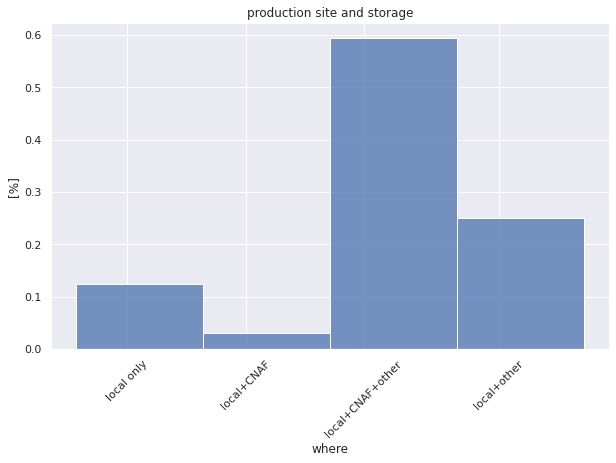

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=pd, x="Experiment", y="where stored")
sns.histplot(data=pd, x="where stored", stat='probability', bins=4)
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production site and storage")
plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])

plt.show()

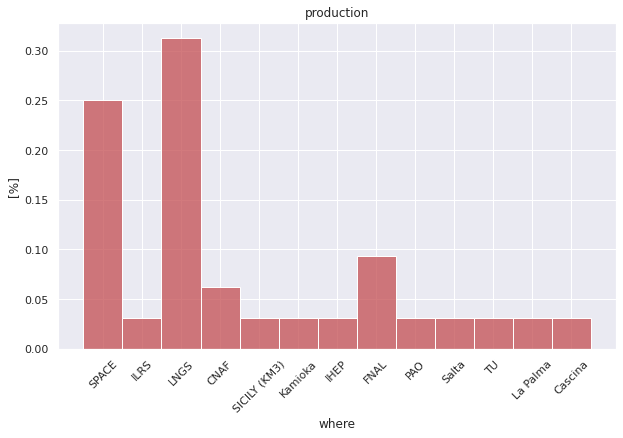

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
#sns.barplot(data=pd, x="Experiment", y="where stored")
sns.histplot(data=pd, x="where", stat='probability', bins=13, color='r')
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel="where", ylabel="[%]", title="production")
#plt.xticks([0.3,1,1.7,2.5], labels = ["local only", "local+CNAF", "local+CNAF+other", "local+other"])
plt.show()

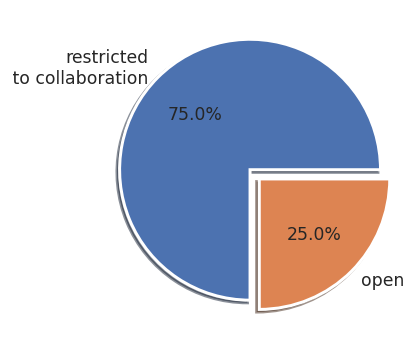

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
#colors = ["g", "w", "k", "y", "c"]
explode = [0, 0.1]
labels = ["restricted\n to collaboration", "open"]
elements = len(pd["public"])
ax.pie(x=pd.value_counts(pd["public"]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
plt.show()

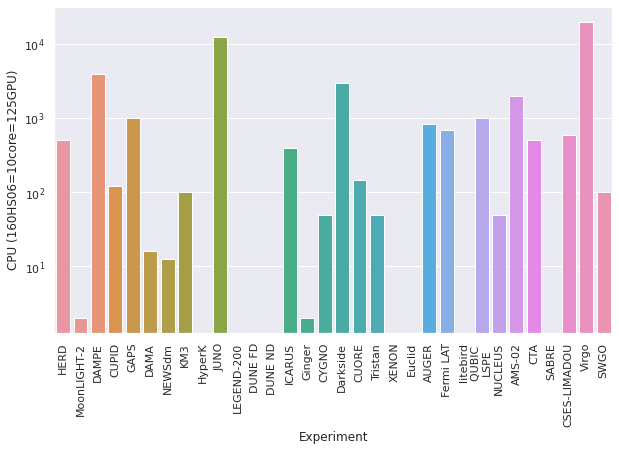

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="CPU (160HS06=10core=125GPU)")
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
#ax.set_ylabel("Ev size [KB]")
plt.show()

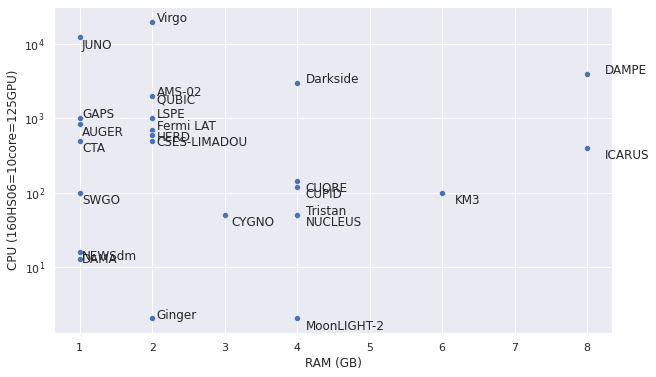

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=pd[pd["CPU (160HS06=10core=125GPU)"]>0], x="RAM (GB)", y="CPU (160HS06=10core=125GPU)")
for i in range(pd.shape[0]):
  if pd["CPU (160HS06=10core=125GPU)"][i]>0:
    x=pd["RAM (GB)"][i]+pd["RAM (GB)"][i]*0.03
    y=pd["CPU (160HS06=10core=125GPU)"][i]-pd["CPU (160HS06=10core=125GPU)"][i]*(i%2)*0.3
    plt.text(x=x, y=y, s=pd["Experiment"][i])
#ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
#ax.set_xscale('log')
#ax.set_ylabel("Ev size [KB]")
#ax.set_ylim(0,5000)
plt.show()

In [15]:
pd[pd["CPU (160HS06=10core=125GPU)"]>0]["CPU (160HS06=10core=125GPU)"].sum()*16

762960.0

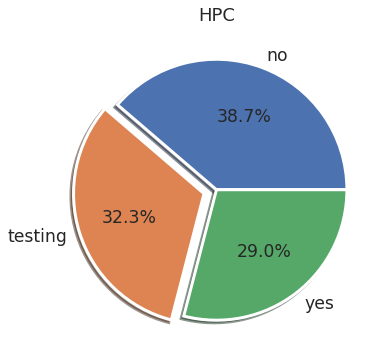

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
colors = ["g", "w", "k"]
explode = [0, 0.1, 0]
labels = ["no", "testing", "yes"]
elements = len(pd["HPC"])
ax.pie(x=pd.value_counts(pd["HPC"]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
ax.set_title('HPC', fontsize=18)
plt.show()

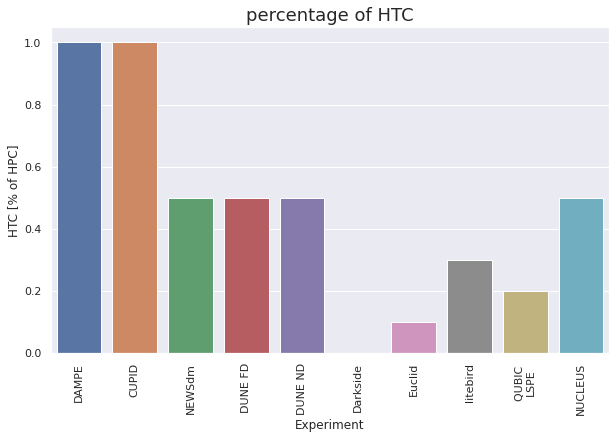

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd[pd["HPC"]>1], x="Experiment", y="HTC")
ax.tick_params(axis='x', rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("HTC [% of HPC]")
ax.set_title('percentage of HTC', fontsize=18)
plt.show()

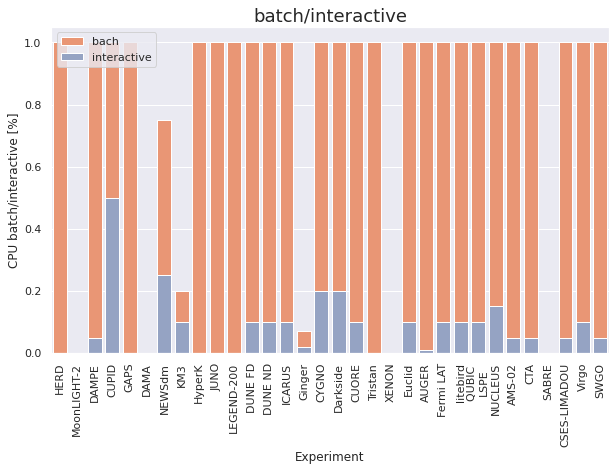

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
pd['total'] = pd.interactive+pd.batch
sns.barplot(data=pd, x="Experiment", y="total", color=sns.color_palette("Set2", 10)[1], label="bach")
sns.barplot(data=pd, x="Experiment", y="interactive", color=sns.color_palette("Set2", 10)[2], label="interactive")
ax.tick_params(axis='x', rotation=90)
#ax.set_yscale('log')
ax.set_ylabel("CPU batch/interactive [%]")
ax.set_title('batch/interactive', fontsize=18)
plt.legend()
plt.show()

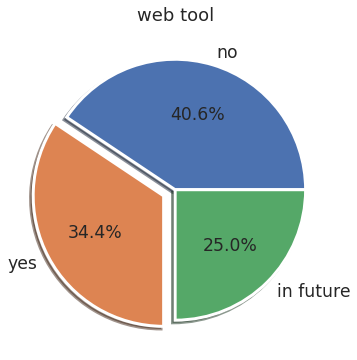

In [19]:
def maybe_pie(dbframe,what):
  fig, ax = plt.subplots(figsize=(6,6))
  explode = [0, 0.1, 0]
  labels = ["no", "yes", "in future"]
  elements = len(dbframe[what])
  ax.pie(x=dbframe.value_counts(dbframe[what]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
      textprops={'size': 'x-large'})
  ax.set_title(what, fontsize=18)
  plt.show()
def yesno_pie(dbframe, what):
  fig, ax = plt.subplots(figsize=(6,6))
  explode = [0, 0.1]
  labels = ["no", "yes"]
  elements = len(dbframe[what])
  ax.pie(x=dbframe.value_counts(dbframe[what]), labels=labels, autopct='%.1f%%', shadow=True, explode=explode,
      wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
      textprops={'size': 'x-large'})
  ax.set_title(what, fontsize=18)
  plt.show()
maybe_pie(pd,"web tool")

In [20]:
pd.columns

Index(['Timestamp', 'Email Address', 'Experiment', 'DAQ type',
       'Data organization', 'DAQ rate events/y', 'Data amount', 'size KB',
       'Data size', 'Data structure', 'Metadata/calibrations/slow-control',
       'Production sites', 'where', 'where stored', 'Workflow', 'Data access',
       'public', 'Details', 'Details, "arrows"', 'Details, "boxes"',
       'CPU - total amount', 'CPU (160HS06=10core=125GPU)', 'RAM (GB)',
       'CPU - HPC', 'HPC', 'CPU - HTC', 'HTC', 'CPU - interactive',
       'interactive', 'CPU - batch system', 'batch', 'CPU - web based tools',
       'web tool', 'CPU - personal VMs', 'personal VMs',
       'CPU - graphic access', 'graphic access', 'CPU - services', 'services',
       'CPU - temporary overpledge', 'temporary overpledge',
       'CPU - special environment', 'special environment', 'CPU - R&D', 'R&D',
       'Storage - size', 'TB', 'file size GB', 'Storage - experiment data',
       'experiment data', 'Storage - user data', 'Storage - secondar

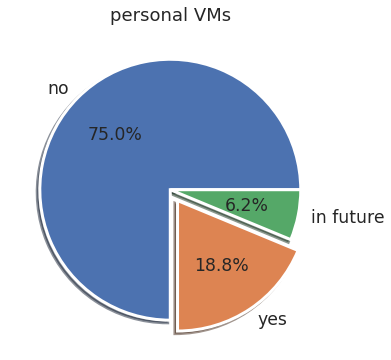

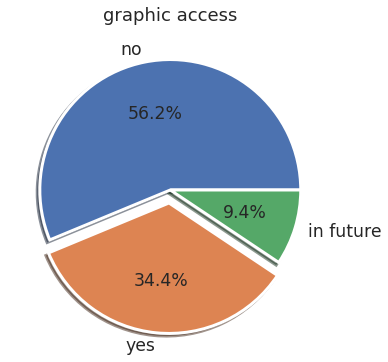

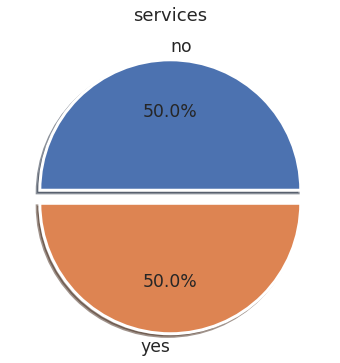

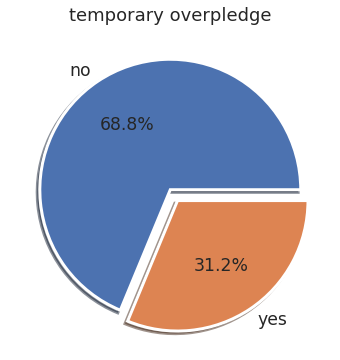

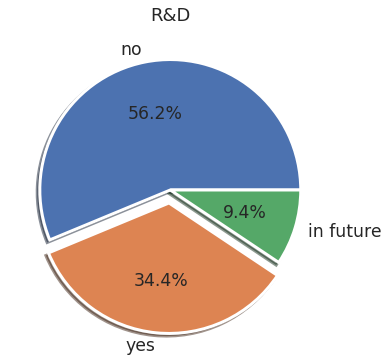

In [21]:
maybe_pie(pd,"personal VMs")
maybe_pie(pd,"graphic access")
yesno_pie(pd,"services")
yesno_pie(pd,"temporary overpledge")
#maybe_pie("special environment")
maybe_pie(pd,"R&D")



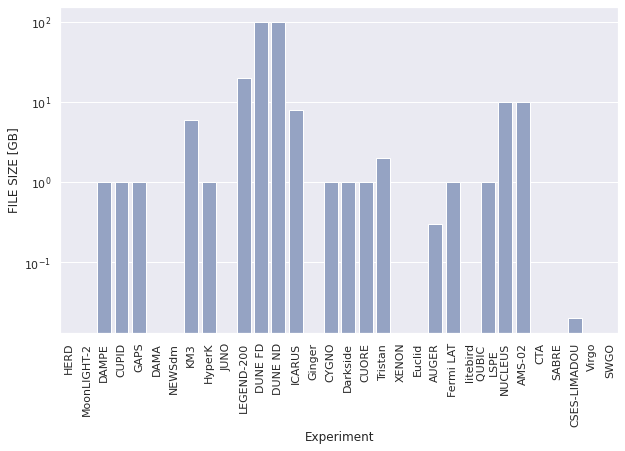

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="file size GB", color=sns.color_palette("Set2", 10)[2])
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("FILE SIZE [GB]")
plt.show()

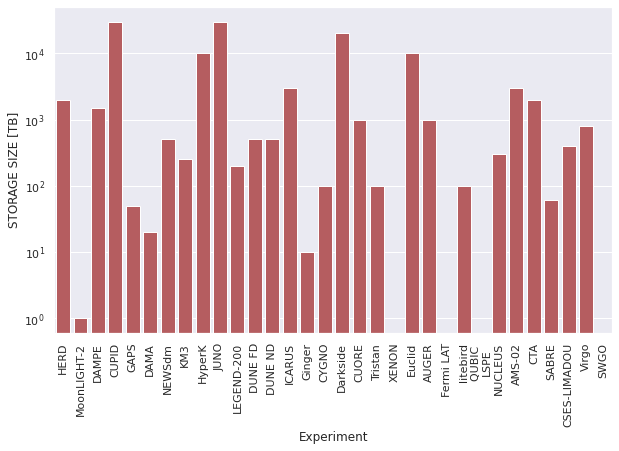

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="TB", color='r')
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("STORAGE SIZE [TB]")
plt.show()

In [24]:
pd[pd.TB>0].TB.sum()/1000


117.391

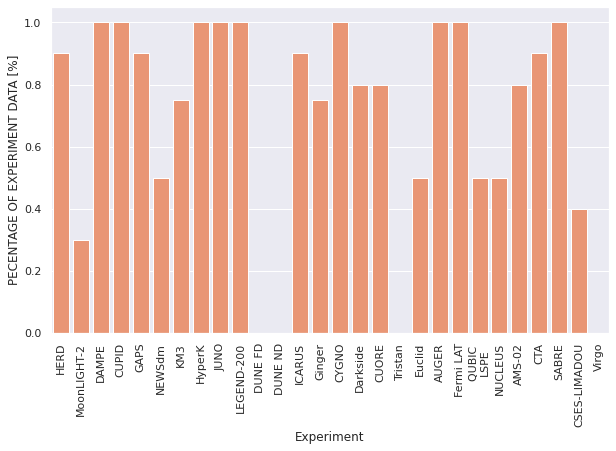

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd[pd["experiment data"]>=0], x="Experiment", y="experiment data", color=sns.color_palette("Set2", 10)[1])
ax.tick_params(axis='x', rotation=90)
# ax.set_yscale('log')
ax.set_ylabel("PECENTAGE OF EXPERIMENT DATA [%]")
plt.show()

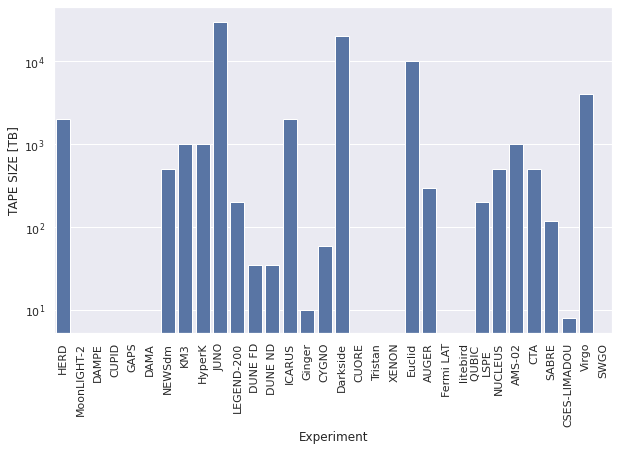

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=pd, x="Experiment", y="tape size", color='b')
ax.tick_params(axis='x', rotation=90)
ax.set_yscale('log')
ax.set_ylabel("TAPE SIZE [TB]")
plt.show()

In [27]:
pd[pd["tape size"]>0]["tape size"].sum()/1000

73.468